# HOT and LOT Region Sequence Generation for Worm

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate

from Bio import SeqIO

In [38]:

genome_path = '../genomes/Worm/'
hot_regions_worm = ['../genomes/Worm/maphot_ce_selection_reg_cx_denP01_all.bed', '../genomes/Worm/maphot_ce_selection_reg_cx_denP05_any.bed']  
output_hot_worm = [ '../hot_lot_seqs/worm/hot_region_01_all.fa', '../hot_lot_seqs/worm/hot_region_05_any.fa']
output_lot_worm = [ '../hot_lot_seqs/worm/lot_region_01_all.fa', '../hot_lot_seqs/worm/lot_region_05_any.fa']

multiplier = 1

In [19]:
""" 
chr_dict    :   bp seq of each chromosome from the given folder of a species.
"""
import os 
# converts the genome file to a dictionary with chromosome keys mapping to their corresponding base pair sequences
chr_dict = {}
for filenames in os.listdir(genome_path):
    if filenames.endswith('.fa'):
        with open(os.path.join(genome_path, filenames)) as myfile:
            recordX = SeqIO.to_dict(SeqIO.parse(myfile, "fasta"))
            #print(recordX)
            k =list(recordX.keys())[0]
            chr_dict[k] = recordX[k]
chr_dict = dict(sorted(chr_dict.items()))


In [60]:
#chr_dict

# HOT regions index in each chromosome

The following cell parses the .bed file and saves the relevant information into a list:
- **line[0]** - chromosome number
- **line[1]** - start position (inclusive)
- **line[2]** - end position (exclusive)
- **line[3]** - HOT region name

In [46]:
"""  
 Input the file that contains HOT regions from each chromosome
"""
with open(hot_regions_worm[1]) as f: #### input file for hot regions
    lines = f.readlines()
    lines = [line.rstrip().split()[0:4] for line in lines]
    for line in lines:
        line[0] = 'chr'+line[0]
    

In [47]:
print(len(lines))
lines[0:4]

20139


[['chrI', '16632', '17470', 'HOT-EX.1'],
 ['chrI', '26807', '27346', 'HOT-EX.2'],
 ['chrI', '39631', '40124', 'HOT-EX.3'],
 ['chrI', '69838', '70749', 'HOT-EX.4']]

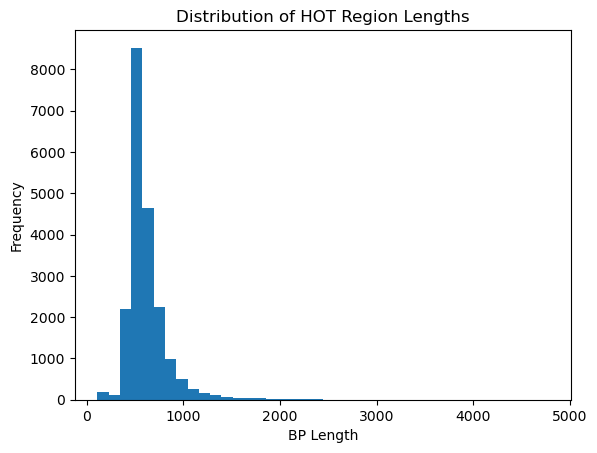

In [61]:
# calculates and plots the distribution of HOT region sequence lengths. 

sizes = []
for entry in lines:
    sizes.append(int(entry[2]) - int(entry[1]))
arr = np.array(sizes)

plt.hist(arr, bins=40)
plt.title('Distribution of HOT Region Lengths')
plt.xlabel('BP Length')
plt.ylabel('Frequency')
plt.show()

# Inverse Transform Sampling for LOT regions

The following cell defines two helper functions to help us perform inverse transform sampling. inv_trans() builds the inverse CDF using interpolation and generate_sample() generates a single sample from the inverse CDF produced by inv_trans. Methods are adapted from:

    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

In [55]:
def inv_trans(data):
    hist, bin_edges = np.histogram(data, bins=40, density=True)
    values = np.zeros(bin_edges.shape)
    values[1:] = np.cumsum(hist*np.diff(bin_edges))
    icdf = interpolate.interp1d(values, bin_edges)
    return icdf

def generate_sample(icdf):
    return round(icdf(np.random.rand(1))[0])

The following cell first finds all the available LOT region index ranges (Logical inverse of HOT region index ranges) and then randomly generates LOT regions through inverse transform sampling on HOT region lengths. The results are stored in a list (negative_set_indices_resized).

In [56]:
index = '0'
curr_chromosome = list(chr_dict.keys())[0]
negative_set_indices = []
icdf = inv_trans(arr)

# Looping over chromosomes to find LOT region index ranges
for entry in lines:
    if entry[0] != curr_chromosome:
        negative_set_indices.append([curr_chromosome, index, len(chr_dict[curr_chromosome].seq)])
        index = '0'
        curr_chromosome = entry[0]
    negative_set_indices.append([curr_chromosome, index, entry[1]])
    index = entry[2]
    
negative_set_indices_resized = []

# Iterating over possible ranges to get LOT regions
for x in negative_set_indices:
    curr_set = set()
    # Generate a random length from HOT region distribution
    l = generate_sample(icdf)
    # Ensuring that the region is long enough to sample from
    if int(x[2])-l < int(x[1]):
        continue
    num = min(multiplier,(int(x[2])-int(x[1]))//10)
    for _ in range(num):
        a = random.randint(int(x[1]), int(x[2])-l)
        # Ensuring nonoverlapping samples
        while any(a>=i and a<= i+l for i in curr_set):
            a = random.randint(int(x[1]), int(x[2])-l)
        curr_set.add(a)
    lis = sorted(list(curr_set))
    for y in lis:
        negative_set_indices_resized.append([x[0], str(y), str(y+l)])

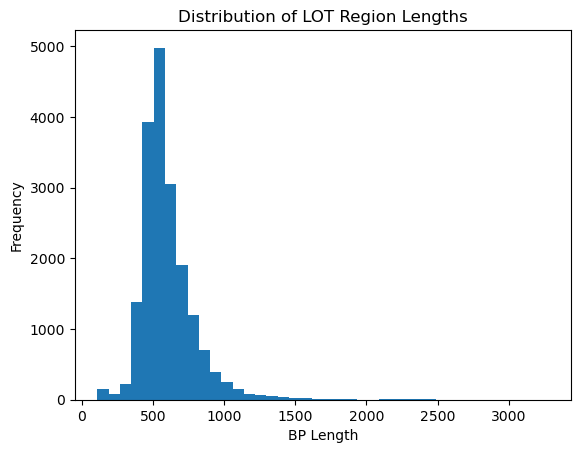

In [57]:
sizes = []
for entry in negative_set_indices_resized:
    sizes.append(int(entry[2]) - int(entry[1]))
arr = np.array(sizes)

plt.hist(arr, bins=40)
plt.title('Distribution of LOT Region Lengths')
plt.xlabel('BP Length')
plt.ylabel('Frequency')
plt.show()

The following cell displays the dataframes containing start and end poitns for HOT regions, raw LOT region data, and the resized LOT regions.

In [64]:
# Printing HOT region indices, LOT region indices, and LOT region resized indices
df1 = pd.DataFrame(lines, columns = ['Chromosome', 'Start', 'End', 'Name'])
print(df1)
# df2 = pd.DataFrame(negative_set_indices, columns = ['Chromosome', 'Start', 'End'])
# display(df2)
df3 = pd.DataFrame(negative_set_indices_resized, columns = ['Chromosome', 'Start', 'End'])
print(df3)

      Chromosome     Start       End         Name
0           chrI     16632     17470     HOT-EX.1
1           chrI     26807     27346     HOT-EX.2
2           chrI     39631     40124     HOT-EX.3
3           chrI     69838     70749     HOT-EX.4
4           chrI    108027    108686     HOT-EX.5
...          ...       ...       ...          ...
20134       chrX  17631562  17632038  HOT-L4.4660
20135       chrX  17632976  17633606  HOT-L4.4661
20136       chrX  17636181  17636788  HOT-L4.4662
20137       chrX  17640647  17641145  HOT-L4.4663
20138       chrX  17714252  17714747  HOT-L4.4664

[20139 rows x 4 columns]
      Chromosome     Start       End
0           chrI      4306      5146
1           chrI     21308     22181
2           chrI     32498     32953
3           chrI     66200     66952
4           chrI     90414     90774
...          ...       ...       ...
18787       chrX  17629469  17629907
18788       chrX  17632078  17632881
18789       chrX  17633636  17634117
1879

The following cell converts the start and end points for HOT and LOT regions into their corresponding base pair sequences and writes them into the specified output files.

In [59]:
""" 
change two output file to store HOT and LOT sequences
"""
# Building HOT Regions fasta file
hot = ''
for entry in lines:
    sequence = str(chr_dict[entry[0]][int(entry[1]):int(entry[2])].seq)
    # Removing any newlines from stored genome entry
    sequence_no_newline = sequence.replace('\n', '')
    hot = hot + '>' + entry[3] + '\n' + sequence_no_newline + '\n'
# Stripping last newline of file
hot =  hot.rstrip('\n') 
with open(output_hot_worm[0],'w+') as f: ### output file for hot sequences
    f.write(hot)
    
# Building LOT Regions fasta file
lot = ''
i = 1
for entry in negative_set_indices_resized:
    sequence = str(chr_dict[entry[0]][int(entry[1]):int(entry[2])].seq)
    # Removing any newlines from stored genome entry
    sequence_no_newline = sequence.replace('\n', '')
    lot = lot + '>LOT.' + str(i) + '\n' + sequence_no_newline + '\n'
    i += 1
# Stripping last newline of file
lot =  lot.rstrip('\n') 
with open(output_lot_worm[0],'w+') as f: ### output file lot sequences
    f.write(lot)